# Find bare soil pixels

In [36]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pickle
from typing import List
from shapely.geometry import Polygon, MultiPolygon
from datetime import datetime, timedelta
import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, os.path.join(base_dir, "eodal"))
import eodal

from datetime import datetime
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs

Settings = get_settings()
# set to False to use a local data archive
Settings.USE_STAC = True

print(f'EOdal version: {eodal.__version__}')

EOdal version: 0.2.4


## Save data for a list of dates and a shp

In [2]:
shp_path = base_dir.joinpath('data/Strickhof.shp')
dates = ['2017-10-07', '2017-12-26']
res_dir = base_dir.joinpath('results/eodal_s2_baresoil') # where to save rasters

In [3]:
aoi = gpd.read_file(shp_path).dissolve()

In [14]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
    interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[3, 8, 9, 10, 11])
    return ds


    

def extract_s2_data(
        aoi: gpd.GeoDataFrame,
        time_start: datetime,
        time_end: datetime,
        scene_cloud_cover_threshold: float = 80,
        feature_cloud_cover_threshold: float = 50,
        spatial_resolution: int = 10
    ) -> SceneCollection:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param time_start:
        start of the time period to extract
    :param end_time:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # setup the metadata filters (cloud cover and processing level)
    metadata_filters = [
        Filter('cloudy_pixel_percentage','<', scene_cloud_cover_threshold),
        Filter('processing_level', '==', 'Level-2A')
    ]
    # setup the spatial feature for extracting data
    feature = Feature.from_geoseries(aoi.geometry)
    
    # set up mapping configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=time_start,
        time_end=time_end,
        feature=feature,
        metadata_filters=metadata_filters
    )

    # get a new mapper instance. Set sensor to `sentinel2`
    mapper = Mapper(mapper_configs)

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.query_scenes()

    # get observations (loads the actual Sentinel2 scenes)
    # the data is extract for the extent of the parcel
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,            # this tells the mapper how to read and load the data (i.e., Sentinel-2 scenes)
        'scene_constructor_kwargs': {},                      # here you could specify which bands to read
        'scene_modifier': preprocess_sentinel2_scenes,       # this tells the mapper about (optional) pre-processing of the loaded scenes (must be a callable)
        'scene_modifier_kwargs': {'target_resolution': 10}   # here, you have to specify the value of the arguments the `scene_modifier` requires
    }
    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # loop over available Sentinel-2 scenes stored in mapper.data as a EOdal SceneCollection and check
    # for no-data. These scenes will be removed from the SceneCollection
    scenes_to_del = []
    mapper.metadata['scene_used'] = 'yes'

    if mapper.data is not None:
        for scene_id, scene in mapper.data:

            # check if scene is blackfilled (nodata); if yes continue
            if scene.is_blackfilled:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
                continue

            # check cloud coverage (including shadows and snow) of the field parcel
            feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

            # if the scene is too cloudy, we skip it
            if feature_cloud_cover > feature_cloud_cover_threshold:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
                continue

            # calculate the NDVI and NBR2
            scene.calc_si('NDVI', inplace=True)
            scene.calc_si('NBR2', inplace=True)

        # delete scenes too cloudy or containing only no-data
        for scene_id in scenes_to_del:
            del mapper.data[scene_id]
    
    return mapper


In [16]:
for d in dates:
  start_date = datetime.strptime(d, '%Y-%m-%d')
  end_date = start_date + timedelta(days=1)
  
  # Query for that date
  mapper = extract_s2_data(
    aoi=aoi,
    time_start=start_date,
    time_end=end_date
  )

  if mapper.data is not None:
    # Save raster for that date
    if not os.path.exists(res_dir):
      os.makedirs(res_dir)
      
    for scened_id, scene in mapper.data:
      scene.to_rasterio(f'{res_dir}/{d}.tif')


2024-01-31 17:00:09,857 eodal        INFO     Starting extraction of sentinel2 scenes


None


2024-01-31 17:00:10,695 eodal        INFO     Finished extraction of sentinel2 scenes
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/eodal/eodal/mapper/mapper.py:887: UserWarning: No scenes were found - consider modifying your search criteria
  warnings.warn(


In [11]:
# Could then open the data and apply thresholds on ndvi and nbr2 and get bare soil

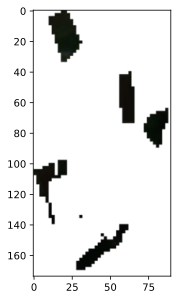

In [43]:
# Check saved data

import rasterio
import matplotlib.pyplot as plt
import numpy as np

with rasterio.open(f'{res_dir}/{d}.tif') as src:
    # Read all bands
    data = src.read()
    rgb = data[[2, 1, 0]]
    rgb[rgb==0] = 1
    plt.imshow(rgb.transpose(1, 2, 0))

## Retrieve dates with baresoil
- add buffer around field/geometry egde
- keep only bare soil pixels

In [2]:
shp_path = base_dir.joinpath('data/Strickhof.shp')
res_dir = base_dir.joinpath('results/eodal_s2_baresoil') # where to save rasters

In [150]:
aoi = gpd.read_file(shp_path).dissolve()
aoi = aoi.to_crs('EPSG:2056')

aoi_with_buffer = aoi.copy()
buffer_distance = -20 # in meters
aoi_with_buffer['geometry'] = aoi.buffer(buffer_distance)
aoi_with_buffer = aoi_with_buffer.to_crs('EPSG:4326')

<Axes: >

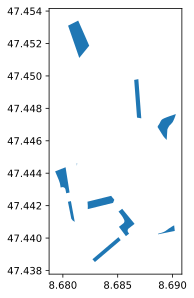

In [151]:
aoi_with_buffer.plot()

<Axes: >

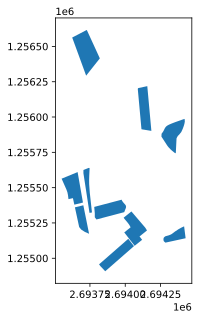

In [146]:
aoi.plot()

In [175]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
    interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[3, 8, 9, 10, 11])
    return ds


    

def extract_s2_data(
        aoi: gpd.GeoDataFrame,
        time_start: datetime,
        time_end: datetime,
        scene_cloud_cover_threshold: float = 50,
        feature_cloud_cover_threshold: float = 80,
        spatial_resolution: int = 10
    ) -> SceneCollection:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param time_start:
        start of the time period to extract
    :param end_time:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # setup the metadata filters (cloud cover and processing level)
    metadata_filters = [
        Filter('cloudy_pixel_percentage','<', scene_cloud_cover_threshold),
        Filter('processing_level', '==', 'Level-2A')
    ]
    # setup the spatial feature for extracting data
    feature = Feature.from_geoseries(aoi.geometry)
    
    # set up mapping configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=time_start,
        time_end=time_end,
        feature=feature,
        metadata_filters=metadata_filters
    )

    # get a new mapper instance. Set sensor to `sentinel2`
    mapper = Mapper(mapper_configs)

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.query_scenes()

    # get observations (loads the actual Sentinel2 scenes)
    # the data is extract for the extent of the parcel
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,            # this tells the mapper how to read and load the data (i.e., Sentinel-2 scenes)
        'scene_constructor_kwargs': {},                      # here you could specify which bands to read
        'scene_modifier': preprocess_sentinel2_scenes,       # this tells the mapper about (optional) pre-processing of the loaded scenes (must be a callable)
        'scene_modifier_kwargs': {'target_resolution': 10}   # here, you have to specify the value of the arguments the `scene_modifier` requires
    }
    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # loop over available Sentinel-2 scenes stored in mapper.data as a EOdal SceneCollection and check
    # for no-data. These scenes will be removed from the SceneCollection
    scenes_to_del = []
    mapper.metadata['scene_used'] = 'yes'
    mapper.metadata['n_bare'] = [0]*len(mapper.metadata)

    if mapper.data is not None:
        for scene_id, scene in mapper.data:

            # check if scene is blackfilled (nodata); if yes continue
            if scene.is_blackfilled:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
                continue

            # check cloud coverage (including shadows and snow) of the field parcel
            feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

            # if the scene is too cloudy, we skip it
            if feature_cloud_cover > feature_cloud_cover_threshold:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
                continue

            # calculate the NDVI and NBR2
            scene.calc_si('NDVI', inplace=True)
            scene.calc_si('NBR2', inplace=True)

            # Check if there are any bare soil pixels
            ndvi = scene.get_band('NDVI').values
            nbr2 =  scene.get_band('NBR2').values
            ndvi.fill_value = np.nan
            nbr2.fill_value = np.nan
            bare_condition = (0 < ndvi) & (ndvi <= 0.25) & (nbr2 <= 0.075)
            bare_soil = np.ma.masked_array(ndvi.data, mask=~bare_condition)
            if not np.sum(~bare_soil.mask): # all pixels are masked -> no bare soil
                scenes_to_del.append(scene_id)
            else:
                #print(scene_id, np.sum(~bare_soil.mask))
                scene.mask(bare_soil.mask, keep_mask_values=True, inplace=True)
                # Save the number of bare soil pixels
                mapper.metadata.loc[mapper.metadata['sensing_date'] == scene_id.date(), 'n_bare'] = np.sum(~bare_soil.mask)
            
                
        # delete scenes too cloudy or containing only no-data or with no bare soil pixels
        for scene_id in scenes_to_del:
            del mapper.data[scene_id]
        # Keep only metadata for corresponding scenes
        dates_to_del = [scene_id.date() for scene_id in scenes_to_del]
        mapper.metadata = mapper.metadata[~mapper.metadata['sensing_date'].isin(dates_to_del)]
    
    return mapper


In [176]:
res_baresoil = extract_s2_data(
  aoi=aoi_with_buffer,
  time_start=datetime(2017,3,1),
  time_end=datetime(2017,5,31)
)

2024-02-01 15:45:55,496 eodal        INFO     Starting extraction of sentinel2 scenes


None


2024-02-01 15:46:13,406 eodal        INFO     Finished extraction of sentinel2 scenes


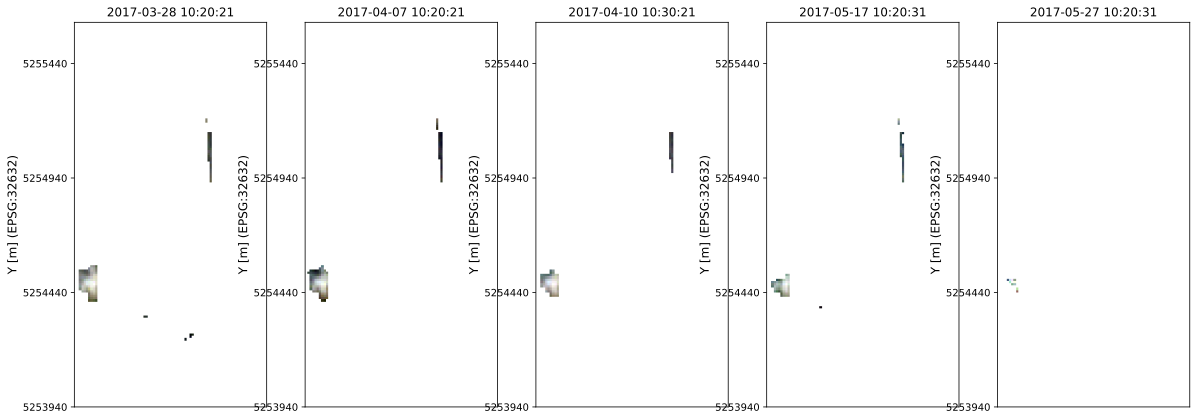

In [185]:
# Plot
scoll = res_baresoil.data
f, axes = plt.subplots(ncols=len(scoll), nrows=1, figsize=(20,14))
idx = 0
for scene_id, scene in scoll:
    scene.plot_multiple_bands(
        band_selection=['red', 'green' ,'blue'],
        ax=axes[idx]
    )
    axes[idx].set_title(scene_id)
    axes[idx].set_xlabel('')
    axes[idx].get_xaxis().set_ticks([])
    idx += 1
    if idx==10:
        break

In [182]:
# Save mapper for reloading later

# Save data for future use
fpath = base_dir.joinpath(f'results/eodal_baresoil_s2_data_test.pkl')
with open(fpath, 'wb+') as dst:
    dst.write(res_baresoil.data.to_pickle())
    
# Also save metadata because we need info on the sensor
metadata_path = fpath.with_name(fpath.name.replace('data', 'metadata'))
with open(metadata_path, 'wb+') as dst:
    pickle.dump(res_baresoil.metadata, dst)

In [39]:
fpath = base_dir.joinpath(f'results/eodal_baresoil_s2_data_test.pkl')
scoll = SceneCollection.from_pickle(stream=base_dir.joinpath(fpath))

metadata_path = fpath.with_name(fpath.name.replace('data', 'metadata'))
metadata = pd.read_pickle(metadata_path)

## Sample bare soil spectra from scenes
- open the save files that are already filtered for bare soil
- sample pixel spectra

In [183]:
fpath = base_dir.joinpath(f'results/eodal_baresoil_s2_data_test.pkl')
scoll = SceneCollection.from_pickle(stream=base_dir.joinpath(fpath))

metadata_path = fpath.with_name(fpath.name.replace('data', 'metadata'))
metadata = pd.read_pickle(metadata_path)

In [263]:
# Sample from top 5 days where there are most bare soil pixels

samples = []

for i, row in metadata.sort_values(by='n_bare', ascending=False).head(5).iterrows():
  date = row['sensing_date']
  sensor = row['spacecraft_name']

  # Get scene for that date
  scoll_idx = [i for i, _ in scoll if i.date()==date][0]
  scene = scoll.__getitem__(scoll_idx) # get scene collection

  # Get pixels in scene
  pixs = scene.to_dataframe()

  # Add some useful metadata: sensing date, sensor
  pixs['sensing_date'] = [date]*len(pixs)
  pixs['sensor'] = [sensor]*len(pixs)

  # Get the pixels with min, max and median SWI (soil moisture index)
  pixs['SWI'] = (pixs.B08 - pixs.B11)*(pixs.B08 / pixs.B11)
  min_swi_row = pixs.loc[pixs['SWI'].idxmin()]
  max_swi_row = pixs.loc[pixs['SWI'].idxmax()]
  # Calculate median SWI and find the closest row
  median_swi = pixs['SWI'].median()
  closest_to_median_row = pixs.iloc[(pixs['SWI'] - median_swi).abs().argsort()[:1]].iloc[0]
  
  # Append the sampled rows to the list
  samples.extend([min_swi_row, max_swi_row, closest_to_median_row])

# Convert GeoDataFrames to DataFrames before creating the final DataFrame
df_sampled = pd.DataFrame([gdf.to_dict() for gdf in samples])

In [264]:
df_sampled

,geometry,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,SCL,NDVI,NBR2,sensing_date,sensor,SWI
0,POINT (475880 5254520),0.0900,0.1262,0.1638,0.2068,0.2258,0.2346,0.2292,0.2539,0.3304,0.3049,5,0.166412,0.040139,2017-03-28,Sentinel-2A,-0.070203
1,POINT (475850 5254460),0.1034,0.1526,0.1926,0.1903,0.2349,0.2578,0.2648,0.2652,0.2820,0.2555,5,0.157849,0.049302,2017-03-28,Sentinel-2A,-0.016151
2,POINT (475900 5254510),0.1056,0.1606,0.2022,0.2195,0.2512,0.2634,0.2684,0.2796,0.3301,0.3102,5,0.140671,0.031079,2017-03-28,Sentinel-2A,-0.050167
3,POINT (475880 5254520),0.0968,0.1400,0.1738,0.2181,0.2384,0.2613,0.2486,0.2801,0.3359,0.3139,5,0.177083,0.033857,2017-04-07,Sentinel-2A,-0.064611
4,POINT (476390 5255160),0.0808,0.1220,0.1520,0.1441,0.2329,0.2664,0.2474,0.2814,0.2333,0.2070,4,0.238858,0.059732,2017-04-07,Sentinel-2A,0.014952
5,POINT (476400 5255080),0.0901,0.1234,0.1548,0.1686,0.1957,0.2089,0.2208,0.2227,0.2754,0.2576,5,0.175719,0.033396,2017-04-07,Sentinel-2A,-0.043775
6,POINT (475880 5254450),0.0925,0.1312,0.1700,0.2027,0.2169,0.2369,0.2214,0.2402,0.3043,0.2775,5,0.131323,0.046064,2017-04-10,Sentinel-2A,-0.060316
7,POINT (475890 5254540),0.0960,0.1370,0.1656,0.1773,0.2110,0.2318,0.2548,0.2450,0.2766,0.2416,5,0.212179,0.067541,2017-04-10,Sentinel-2A,-0.020082
8,POINT (475850 5254490),0.0963,0.1396,0.1736,0.1872,0.2156,0.2224,0.2292,0.2363,0.2836,0.2489,5,0.138034,0.065164,2017-04-10,Sentinel-2A,-0.043965
9,POINT (475880 5254450),0.1058,0.1578,0.1924,0.2474,0.2699,0.2807,0.2678,0.3026,0.3628,0.3396,5,0.163842,0.033030,2017-05-17,Sentinel-2A,-0.070124


## Resample to 1nm resolution

In [239]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [240]:
s2a = [492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 1613.7, 2202.4]
s2b = [492.1, 559.0, 664.9, 703.8, 739.1, 779.7, 832.9, 864.0, 1610.4, 2185.7]
new_wavelengths = np.arange(400, 2501, 1)

In [241]:
def upsample_spectra(df, wavelengths, new_wavelengths):
    # Interpolate along the rows (pixels) for each wavelength
    interpolated_data = {}
    for index, row in df.iterrows():
        f = interp1d(wavelengths, row, kind='cubic', fill_value="extrapolate")
        interpolated_data[index] = f(new_wavelengths)

    # Create a new DataFrame with the interpolated data
    interpolated_df = pd.DataFrame(interpolated_data, index=new_wavelengths)

    # Transpose the DataFrame to have pixels as columns
    interpolated_df = interpolated_df.T

    # Print the result
    return interpolated_df

In [267]:
s2a_df = df_sampled[df_sampled['sensor'] == 'Sentinel-2A']
s2b_df = df_sampled[df_sampled['sensor'] == 'Sentinel-2B']
df_list = [s2a_df, s2b_df]

spectra = pd.DataFrame()

for df in df_list:
  if len(df):
    s2_vals = df[['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']]

    # Resample to 1nm
    if np.unique(df.sensor) == 'Sentinel-2A':
      df_new = upsample_spectra(s2_vals, s2a, new_wavelengths)
    if np.unique(df.sensor) == 'Sentinel-2B':
      df_new = upsample_spectra(s2_vals, s2b, new_wavelengths)
    
    # Append
    spectra = pd.concat([spectra, df_new])


# TO DO: export spectra as txt file or other


In [189]:
"""
spectra = pd.DataFrame()

for scene_id, scene in scoll:
  # Get some pixels from that scene (could aslo additionally filter with SCL)
  pixs = scene.to_dataframe().sample(5)
  pixs_s2 = pixs[['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']]
  # Get sensor
  sensor = metadata[metadata.sensing_date == scene_id.date()].spacecraft_name.values
  print(sensor)
  # Resample to 1nm
  if sensor == 'Sentinel-2A':
    df = upsample_spectra(pixs_s2, s2a, new_wavelengths)
  if sensor == 'Sentinel-2B':
    df = upsample_spectra(pixs_s2, s2b, new_wavelengths)
  # Append
  spectra = pd.concat([spectra, df])
  break

# TO DO: export spectra as txt file or other
"""

['Sentinel-2A']


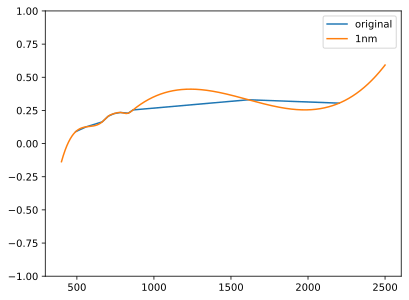

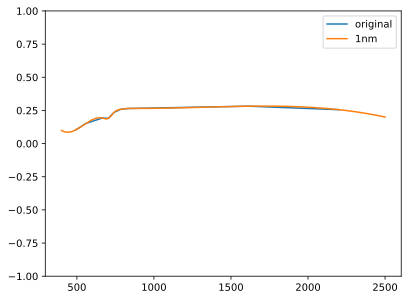

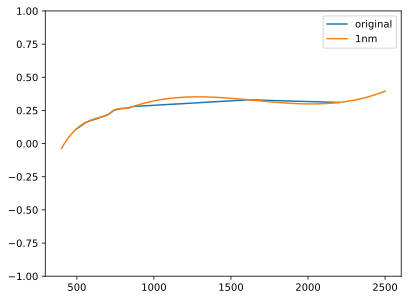

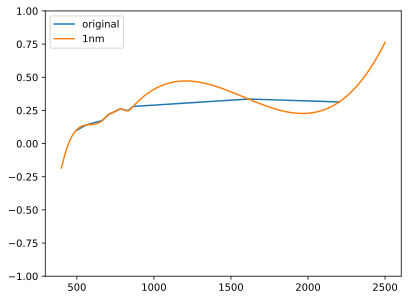

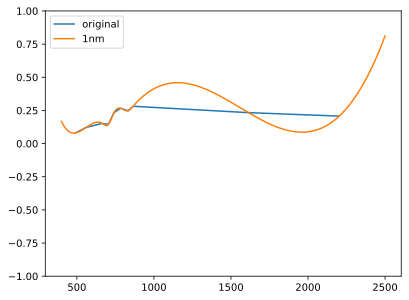

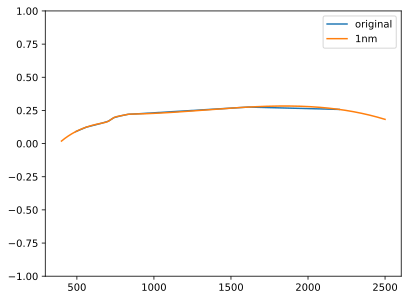

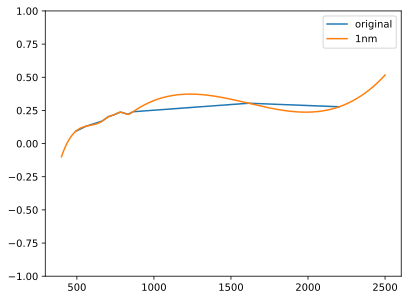

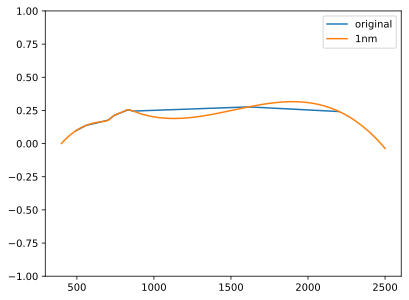

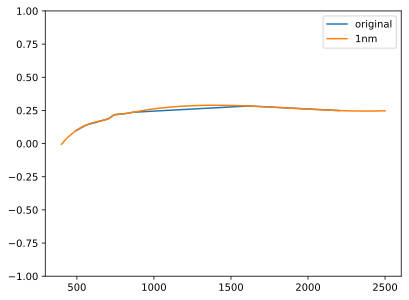

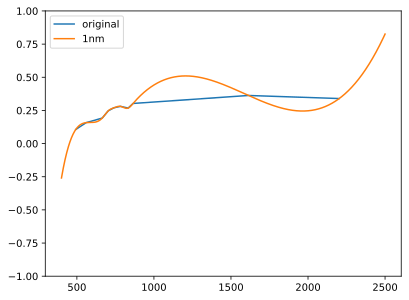

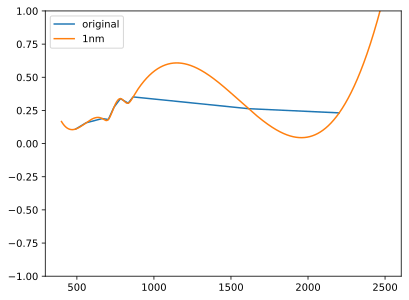

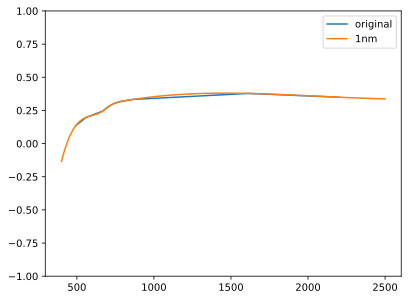

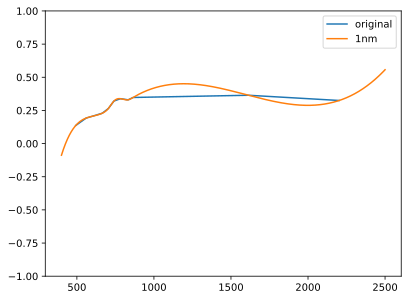

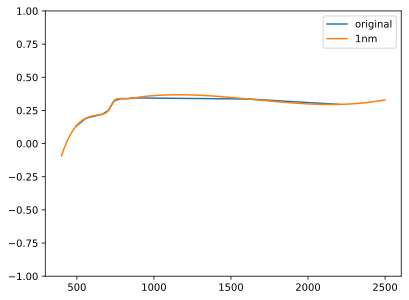

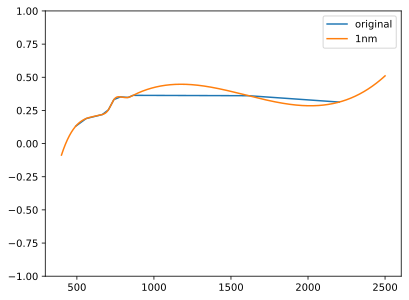

In [276]:
# Compare before and after
df_sampled_s2 = df_sampled[['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']]

for i, r in df_sampled_s2.iterrows():
  plt.plot(s2a, r, label='original')
  plt.plot(new_wavelengths, spectra.loc[i], label=f'1nm')
  plt.legend()
  plt.ylim((-1,1))
  plt.show()